# "Hallelujah Effect" Analysis with SVMs

This notebook models the "Hallelujah Effect" in terms of all basic features available in the dataset for those subjects that listened to the song and had an EDA quality >80% using various SVM models.

In [1]:
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn import metrics

In [2]:
# Set bucket, project, and region
BUCKET = 'eim-muse'
PROJECT = 'eim-muse'
REGION = 'us-east1'

In [3]:
# Set a random state variable for repeatability
RANDOM_STATE = 42

In [4]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [5]:
%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


## Retrieve and Subset Datasource

Get data from BigQuery but defer filtering, etc. to Beam. Data in BigQuery has been pre-processed with Dataprep.

In [6]:
import google.datalab.bigquery as bq
def create_query(phase, EVERY_N):
  """
  phase: 1=train 2=valid
  """
  base_query = """
SELECT *
FROM
  `eim-muse.hallelujah_effect.full_hallelujah_trials_cleaned`
  """

  if EVERY_N == None:
    if phase < 2:
      # Training
      query = "{0} WHERE MOD(FARM_FINGERPRINT(id), 10) < 7".format(base_query)
    else:
      # Validation
      query = "{0} WHERE MOD(FARM_FINGERPRINT(id), 10) >= 7".format(base_query)
  else:
      query = "{0} WHERE MOD(FARM_FINGERPRINT(id), {1}) = {2}".format(base_query, EVERY_N, phase)
    
  return query

query = create_query(1, None)

In [7]:
df_all = bq.Query(query).execute().result().to_dataframe()
df_all.head()
df_all.describe()

,age,concentration,musical_expertise,artistic,fault,imagination,lazy,nervous,outgoing,reserved,...,music_pref_none,music_pref_hiphop,music_pref_dance,music_pref_world,music_pref_rock,music_pref_pop,music_pref_classical,music_pref_jazz,music_pref_folk,music_pref_traditional_irish
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,...,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,24.726073,3.993500,2.547224,2.344099,3.175612,3.852643,3.690403,3.629726,3.213016,3.145503,...,0.006601,0.138614,0.188119,0.132013,0.432343,0.673267,0.306931,0.171617,0.089109,0.059406
std,13.931034,0.795258,1.009324,0.988361,0.891464,0.821620,0.905895,0.875898,0.961299,0.891699,...,0.081110,0.346115,0.391454,0.339065,0.496221,0.469794,0.461983,0.377671,0.285372,0.236774
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,3.991266,2.000000,2.000000,3.000000,3.824561,3.659389,3.596491,3.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,21.000000,3.991266,2.529880,2.353712,3.144737,3.824561,3.659389,3.596491,3.228070,3.117904,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,31.000000,4.000000,3.000000,2.353712,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,121.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
train_query = create_query(1, None)
train_n = len(list(bq.Query(train_query).execute().result()))

eval_query = create_query(2, None)
eval_n = len(list(bq.Query(eval_query).execute().result()))

os.environ['TRAIN_N'] = str(train_n)
os.environ['EVAL_N'] = str(eval_n)

print('{} training examples / {} evaluation examples'.format(train_n, eval_n))

303 training examples / 61 evaluation examples


In [9]:
df_all.columns

Index(['id', 'age', 'concentration', 'hearing_impairments',
       'musical_expertise', 'nationality', 'artistic', 'fault', 'imagination',
       'lazy', 'nervous', 'outgoing', 'reserved', 'stress', 'thorough',
       'trusting', 'activity', 'engagement', 'familiarity', 'like_dislike',
       'positivity', 'tension', 'sex', 'hallelujah_reaction', 'location',
       'language', 'music_pref_none', 'music_pref_hiphop', 'music_pref_dance',
       'music_pref_world', 'music_pref_rock', 'music_pref_pop',
       'music_pref_classical', 'music_pref_jazz', 'music_pref_folk',
       'music_pref_traditional_irish'],
      dtype='object')

In [10]:
df_train = bq.Query(train_query).execute().result().to_dataframe()
df_train.head()
df_train.describe()

,age,concentration,musical_expertise,artistic,fault,imagination,lazy,nervous,outgoing,reserved,...,music_pref_none,music_pref_hiphop,music_pref_dance,music_pref_world,music_pref_rock,music_pref_pop,music_pref_classical,music_pref_jazz,music_pref_folk,music_pref_traditional_irish
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,...,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,24.726073,3.993500,2.547224,2.344099,3.175612,3.852643,3.690403,3.629726,3.213016,3.145503,...,0.006601,0.138614,0.188119,0.132013,0.432343,0.673267,0.306931,0.171617,0.089109,0.059406
std,13.931034,0.795258,1.009324,0.988361,0.891464,0.821620,0.905895,0.875898,0.961299,0.891699,...,0.081110,0.346115,0.391454,0.339065,0.496221,0.469794,0.461983,0.377671,0.285372,0.236774
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,3.991266,2.000000,2.000000,3.000000,3.824561,3.659389,3.596491,3.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,21.000000,3.991266,2.529880,2.353712,3.144737,3.824561,3.659389,3.596491,3.228070,3.117904,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,31.000000,4.000000,3.000000,2.353712,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,121.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df_eval = bq.Query(eval_query).execute().result().to_dataframe()
df_eval.head()
df_eval.describe()

,age,concentration,musical_expertise,artistic,fault,imagination,lazy,nervous,outgoing,reserved,...,music_pref_none,music_pref_hiphop,music_pref_dance,music_pref_world,music_pref_rock,music_pref_pop,music_pref_classical,music_pref_jazz,music_pref_folk,music_pref_traditional_irish
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,...,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,24.016393,3.980170,2.443733,2.401460,2.991372,3.685073,3.505333,3.431406,3.302847,2.980815,...,0.016393,0.114754,0.213115,0.147541,0.409836,0.704918,0.327869,0.213115,0.049180,0.065574
std,11.491289,0.805997,0.985933,0.828365,0.861184,0.910025,0.947435,0.848395,0.881794,0.878552,...,0.128037,0.321370,0.412907,0.357588,0.495885,0.459865,0.473333,0.412907,0.218039,0.249590
min,5.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,3.991266,2.000000,2.000000,3.000000,3.824561,3.659389,3.000000,3.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,21.000000,3.991266,2.529880,2.353712,3.144737,3.824561,3.659389,3.596491,3.228070,3.117904,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,4.000000,3.000000,3.000000,3.144737,4.000000,4.000000,4.000000,4.000000,3.117904,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,56.000000,5.000000,5.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
def preprocess_df(df, scaling_dict=None):
  """
  Preprocess a dataframe for this analysis.
  
  If a scaling dict is provided, columns are scaled between 0 and 1. If a scaling
  dict is provided, each column name in the dataframe should have a key in the 
  scaling dict with the same name. The value of this key should itself be a dict
  with 'min' and 'max' keys.
  
  If no scaling dict is provided, one is calculated and returned in the response. 
  This scaling dict can then be used in transforming another dataset (for example,
  to apply the same transformation to an evaluation dataset that was used in scaling 
  a training dataset).
  """

  updated_df = df.drop(columns=['id', 'hallelujah_reaction'])

  updated_df = pd.concat(
    [
      updated_df.drop(columns=['location', 'nationality', 'sex', 'language']), 
      pd.get_dummies(updated_df['location'], prefix='location'),
      pd.get_dummies(updated_df['nationality'], prefix='nationality'),
      pd.get_dummies(updated_df['sex'], prefix='sex'),
      pd.get_dummies(updated_df['language'], prefix='language')
    ], 
    axis=1
  )

  updated_df = updated_df.apply(pd.to_numeric)

  if scaling_dict is None:
    scaling_dict = {}
    for column in updated_df.columns:
      scaling_dict[column] = {
        'max': updated_df[column].max(),
        'min': updated_df[column].min()
      }
  
  for column in updated_df.columns:
    if column not in scaling_dict.keys():
      updated_df = updated_df.drop(columns=[column])
    else:
      updated_df[column] = np.subtract(updated_df[column], scaling_dict[column]['min'], dtype=np.float32)
      updated_df[column] = updated_df[column] / np.subtract(scaling_dict[column]['max'], scaling_dict[column]['min'], dtype=np.float32)

  return updated_df, scaling_dict

In [13]:
# Preprocess the training and eval dataframes

# First, preprocess the training set and save the scaling_dict
df_train_X, df_train_scaling_dict = preprocess_df(df_train)
df_train_y = df_train['hallelujah_reaction']

# Now, preprocess the evaluation set, but use the same scaling parameters
# that were calculated for the training set
df_eval_X, _ = preprocess_df(df_eval, scaling_dict=df_train_scaling_dict)
df_eval_y = df_eval['hallelujah_reaction']

# Remove columns from training data that do not exist in eval data
all_columns = list(set(list(df_train_X.columns) + list(df_eval_X.columns)))
good_columns = [column for column in all_columns if column in df_train_X.columns and column in df_eval_X.columns]
df_train_X = df_train_X[good_columns]
df_eval_X = df_eval_X[good_columns]

## Build / Evaluate Baseline Classifier
Construct a baseline classifier for comparison against our other classifiers. Because of class imbalance, this classifier predicts every example to be in the `False` class.

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Results for baseline classifier:


Overall F1 score: 0.0
True positives: 0
True negatives: 41
False positives: 0
False negatives: 20


             precision    recall  f1-score   support

      False       0.67      1.00      0.80        41
       True       0.00      0.00      0.00        20

avg / total       0.45      0.67      0.54        61



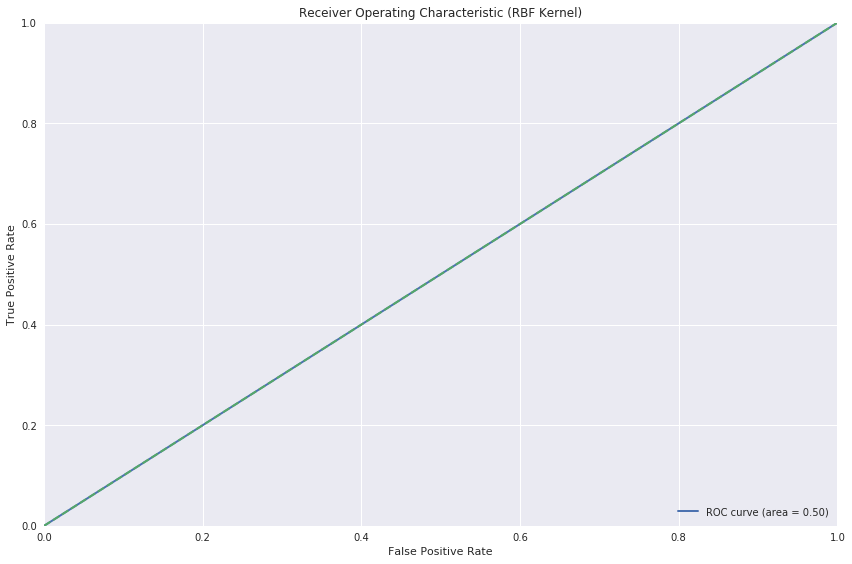

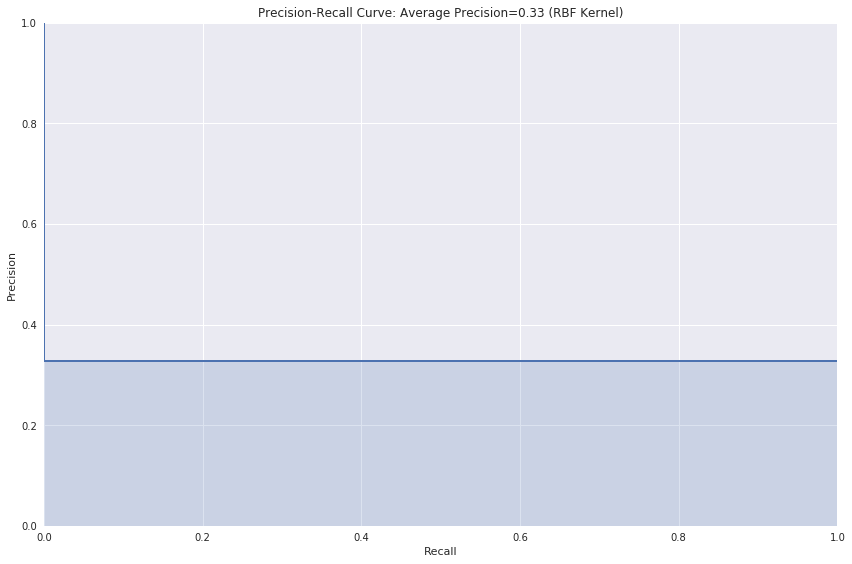

In [14]:
def get_baseline_classifier(df_train_X, df_train_y, df_eval_X, df_eval_y):

  from sklearn.dummy import DummyClassifier

  classifier_baseline = DummyClassifier(strategy='constant', random_state=RANDOM_STATE, constant=False)
  classifier_baseline = classifier_baseline.fit(df_train_X, df_train_y)

  # Evaluate with evaluation set
  eval_true = df_eval_y
  eval_preds = classifier_baseline.predict(df_eval_X)
  eval_probs = classifier_baseline.predict_proba(df_eval_X)

  # Compute metrics
  f1 = metrics.f1_score(eval_true, eval_preds)
  tn, fp, fn, tp = metrics.confusion_matrix(eval_true, eval_preds).ravel()
  report = metrics.classification_report(eval_true, eval_preds)

  # Compute ROC curve and ROC area for each class
  fpr, tpr, _ = metrics.roc_curve(eval_true, eval_probs[:,1], pos_label=True)
  roc_auc = metrics.auc(fpr, tpr)

  # Compute PR curve and PR area for each class
  average_precision = metrics.average_precision_score(eval_true, eval_preds)
  precision, recall, _ = metrics.precision_recall_curve(eval_true, eval_probs[:,1], pos_label=True)
  pr_auc = metrics.auc(precision, recall, reorder=True)

  # Print results for best classifier
  print('Results for baseline classifier:')
  print('\n')
  print('Overall F1 score: {}'.format(f1))
  print('True positives: {}'.format(tp))
  print('True negatives: {}'.format(tn))
  print('False positives: {}'.format(fp))
  print('False negatives: {}'.format(fn))
  print('\n')
  print(report)

  # Plot ROC curve for best classifier
  lw = 2
  figure = plt.figure(figsize=(12,8))
  plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (RBF Kernel)')
  plt.legend(loc="lower right")
  plt.tight_layout()

  # Plot precision-recall curve for best classifier
  figure = plt.figure(figsize=(12,8))
  plt.step(recall, precision, where='post', lw=lw)
  plt.fill_between(recall, precision, step='post', alpha=0.2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve: Average Precision={0:0.2f} (RBF Kernel)'.format(average_precision))
  plt.tight_layout()

baseline_classifier = get_baseline_classifier(df_train_X, df_train_y, df_eval_X, df_eval_y)

## Build SVC classifier (RBF Kernel)

Now, we build an SVM classifier and trial various parameters:

- Kernel: RBF, sigmoid, polynomial, linear

for the $C \in [0.01, 100000]$ term in the model (the error penalization term). This model uses a radial basis function (RBF) kernel.

In [ ]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import time

start = time.time()

def get_tuned_classifier(df_train_X, df_train_y):
  scoring = {'F1 Score': 'f1'}
  param_grid = [
    {
#     'C': np.logspace(-2., 3., 10),
#     'coef0': np.logspace(-2., 5., 10),
#     'gamma': np.logspace(-3., 5., 10),
#     'degree': np.arange(2, 13),
    'C': np.logspace(-5, 15, num=21, base=2),
#     'coef0': np.logspace(-2., 5., 5),
    'gamma': np.logspace(-15, 3, num=19, base=2),
#     'degree': [2, 7, 12],
    'kernel': ['rbf']
    #'shrinking': [True, False],
    #'class_weight': ['balanced', None],
    #'decision_function_shape': ['ovr', 'ovo']
#     },
#     {
#       'C': np.logspace(-2., 3., 3),
#       'coef0': np.logspace(-2., 5., 5),
#       'kernel': ['linear']
    }
  ]
  gs = GridSearchCV(SVC(probability=True, random_state=RANDOM_STATE),
                    param_grid=param_grid,
                    scoring=scoring,
                    cv=10,
                    refit='F1 Score',
                    n_jobs=4,
                    verbose=50
                   )
  gs.fit(df_train_X, df_train_y)
  best_classifier = gs.best_estimator_
  return best_classifier

best_tuned_classifier = get_tuned_classifier(df_train_X, df_train_y)
print(best_tuned_classifier)

end = time.time()
print(end - start)

## Build SVM classifier (Sigmoid Kernel)

Now, we build an SVM classifier and trial various parameters for the $C \in [0.01, 100000]$ term in the model (the error penalization term). This model uses a sigmoid kernel.

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Results for classifier with C=0.2913831704832787:


Overall F1 score: 0.48101265822784806
True positives: 19.0
True negatives: 1.0
False positives: 40.0
False negatives: 1.0


             precision    recall  f1-score   support

      False       0.50      0.02      0.05        41
       True       0.32      0.95      0.48        20

avg / total       0.44      0.33      0.19        61



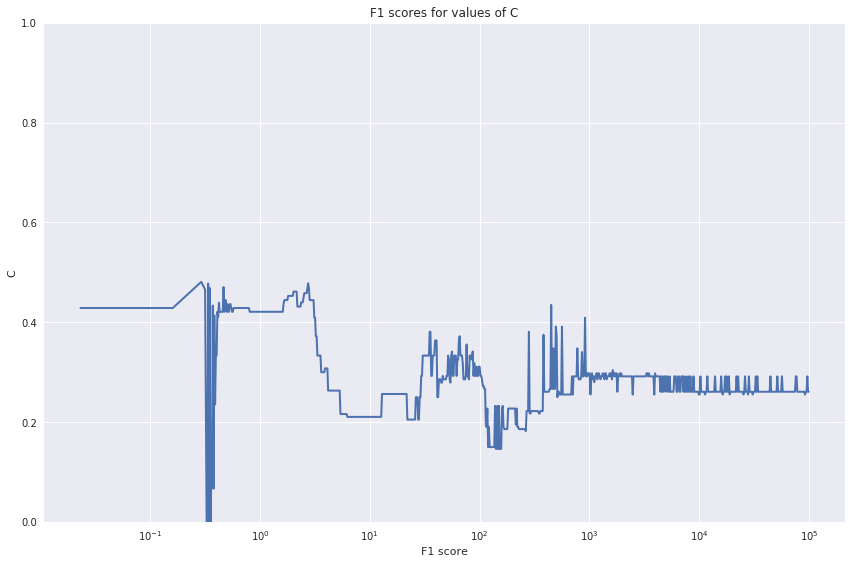

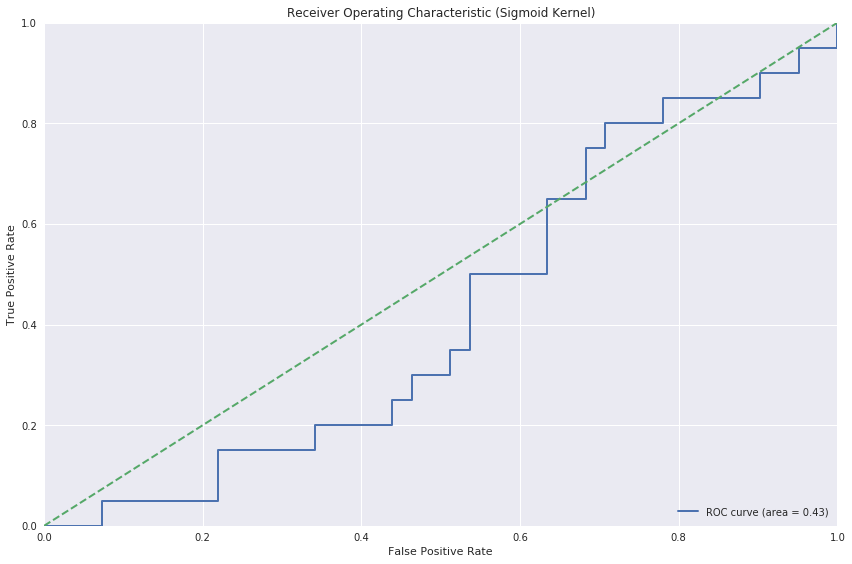

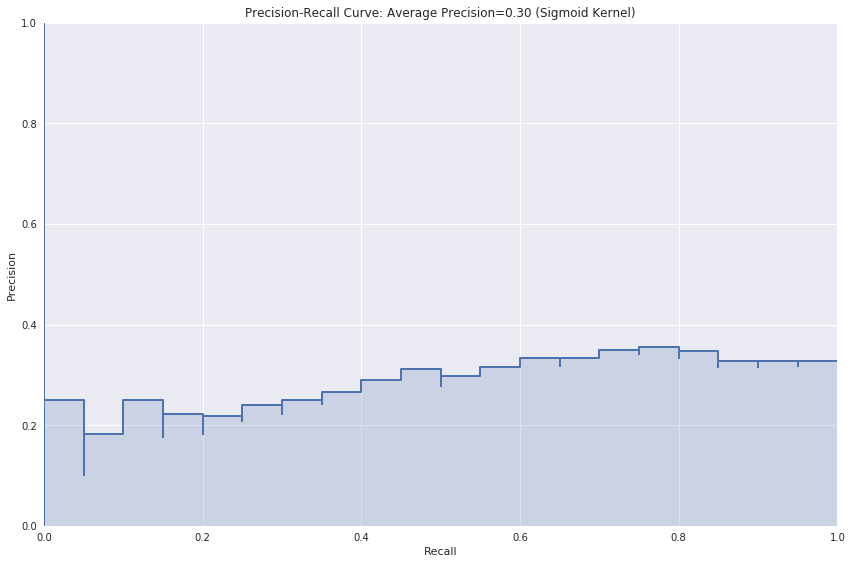

In [16]:
def get_classifier_sigmoid(df_train_X, df_train_y, df_eval_X, df_eval_y):
  # Generate candidate C values on a logarithmic scale between 0.01 and 1000
  C_values = np.logspace(-2., 5., 1000)
  classifier_svc_sigmoid = None
  classifier_svc_sigmoid_results = {
    'classifier': np.array([]), 
    'C': np.array([]), 
    'f1': np.array([]),
    'tp': np.array([]),
    'tn': np.array([]),
    'fp': np.array([]),
    'fn': np.array([]),
    'report': np.array([]),
    'fpr': np.array([]),
    'tpr': np.array([]),
    'roc_auc': np.array([]),
    'average_precision': np.array([]),
    'precision': np.array([]),
    'recall': np.array([]),
    'pr_auc': np.array([])
  }

  # Train a model with each of these C values and output results on eval set
  for C in C_values:

    # Create and fit classifier
    classifier_svc_sigmoid = SVC(C=C, kernel='sigmoid', probability=True, class_weight='balanced', random_state=RANDOM_STATE)
    classifier_svc_sigmoid.fit(df_train_X, df_train_y)

    # Evaluate with evaluation set
    eval_true = df_eval_y
    eval_preds = classifier_svc_sigmoid.predict(df_eval_X)
    eval_probs = classifier_svc_sigmoid.predict_proba(df_eval_X)

    # Compute metrics
    f1 = metrics.f1_score(eval_true, eval_preds)
    tn, fp, fn, tp = metrics.confusion_matrix(eval_true, eval_preds).ravel()
    report = metrics.classification_report(eval_true, eval_preds)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = metrics.roc_curve(eval_true, eval_probs[:,1], pos_label=True)
    roc_auc = metrics.auc(fpr, tpr)

    # Compute PR curve and PR area for each class
    average_precision = metrics.average_precision_score(eval_true, eval_preds)
    precision, recall, _ = metrics.precision_recall_curve(eval_true, eval_probs[:,1], pos_label=True)
    pr_auc = metrics.auc(precision, recall, reorder=True)

    # If we didn't predict everything as one class, save C and F1 score for visualization
    if (tp + fp != 0) and (tn + fn != 0):
      classifier_svc_sigmoid_results['classifier'] = np.append(classifier_svc_sigmoid_results['classifier'], classifier_svc_sigmoid)
      classifier_svc_sigmoid_results['C'] = np.append(classifier_svc_sigmoid_results['C'], C)
      classifier_svc_sigmoid_results['f1'] = np.append(classifier_svc_sigmoid_results['f1'], f1)
      classifier_svc_sigmoid_results['report'] = np.append(classifier_svc_sigmoid_results['report'], report)
      classifier_svc_sigmoid_results['tp'] = np.append(classifier_svc_sigmoid_results['tp'], tp)
      classifier_svc_sigmoid_results['tn'] = np.append(classifier_svc_sigmoid_results['tn'], tn)
      classifier_svc_sigmoid_results['fp'] = np.append(classifier_svc_sigmoid_results['fp'], fp)
      classifier_svc_sigmoid_results['fn'] = np.append(classifier_svc_sigmoid_results['fn'], fn)
      classifier_svc_sigmoid_results['fpr'] = np.append(classifier_svc_sigmoid_results['fpr'], fpr)
      classifier_svc_sigmoid_results['tpr'] = np.append(classifier_svc_sigmoid_results['tpr'], tpr)
      classifier_svc_sigmoid_results['roc_auc'] = np.append(classifier_svc_sigmoid_results['roc_auc'], roc_auc)
      classifier_svc_sigmoid_results['average_precision'] = np.append(classifier_svc_sigmoid_results['average_precision'], average_precision)
      classifier_svc_sigmoid_results['precision'] = np.append(classifier_svc_sigmoid_results['precision'], precision)
      classifier_svc_sigmoid_results['recall'] = np.append(classifier_svc_sigmoid_results['recall'], recall)
      classifier_svc_sigmoid_results['pr_auc'] = np.append(classifier_svc_sigmoid_results['pr_auc'], pr_auc)

  # Plot results from F1 tuning
  lw = 2
  figure = plt.figure(figsize=(12,8))
  plt.plot(classifier_svc_sigmoid_results['C'], classifier_svc_sigmoid_results['f1'], lw=lw)
  plt.xscale('log')
  plt.xlabel('F1 score')
  plt.ylim([0, 1])
  plt.ylabel('C')
  plt.title('F1 scores for values of C')
  plt.tight_layout()

  # Find best classifier
  max_f1_index = classifier_svc_sigmoid_results['f1'].argmax()

  # Print results for best classifier
  best_classifier = classifier_svc_sigmoid_results['classifier'][max_f1_index]
  print('Results for classifier with C={}:'.format(classifier_svc_sigmoid_results['C'][max_f1_index]))
  print('\n')
  print('Overall F1 score: {}'.format(classifier_svc_sigmoid_results['f1'][max_f1_index]))
  print('True positives: {}'.format(classifier_svc_sigmoid_results['tp'][max_f1_index]))
  print('True negatives: {}'.format(classifier_svc_sigmoid_results['tn'][max_f1_index]))
  print('False positives: {}'.format(classifier_svc_sigmoid_results['fp'][max_f1_index]))
  print('False negatives: {}'.format(classifier_svc_sigmoid_results['fn'][max_f1_index]))
  print('\n')
  print(classifier_svc_sigmoid_results['report'][max_f1_index])

  # Plot ROC curve for best classifier
  figure = plt.figure(figsize=(12,8))
  plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (Sigmoid Kernel)')
  plt.legend(loc="lower right")
  plt.tight_layout()

  # Plot precision-recall curve for best classifier
  figure = plt.figure(figsize=(12,8))
  plt.step(recall, precision, where='post', lw=lw)
  plt.fill_between(recall, precision, step='post', alpha=0.2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve: Average Precision={0:0.2f} (Sigmoid Kernel)'.format(average_precision))
  plt.tight_layout()

  # Save best classifier
  return best_classifier

classifier_svc_sigmoid = get_classifier_sigmoid(df_train_X, df_train_y, df_eval_X, df_eval_y)

## Build SVM classifier (3rd Order Polynomial Kernel)

Now, we build an SVM classifier and trial various parameters for the $C \in [0.01, 100000]$ term in the model (the error penalization term). This model uses a 3rd order polynomial kernel.

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Results for classifier with C=1.7188391428171457:


Overall F1 score: 0.5263157894736842
True positives: 20.0
True negatives: 5.0
False positives: 36.0
False negatives: 0.0


             precision    recall  f1-score   support

      False       1.00      0.12      0.22        41
       True       0.36      1.00      0.53        20

avg / total       0.79      0.41      0.32        61



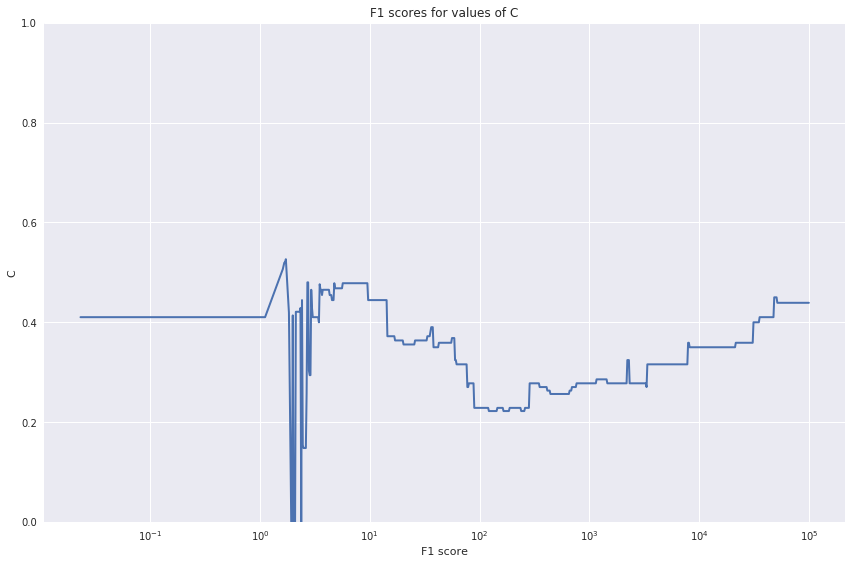

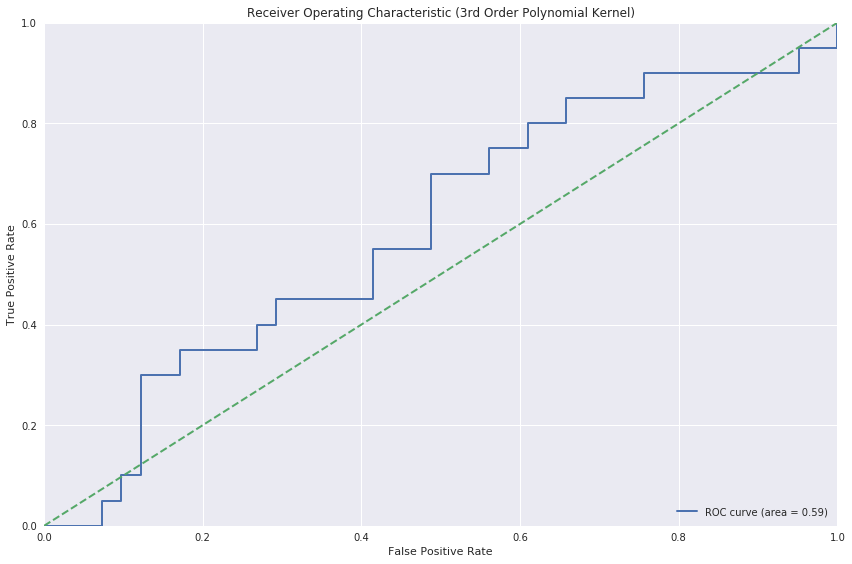

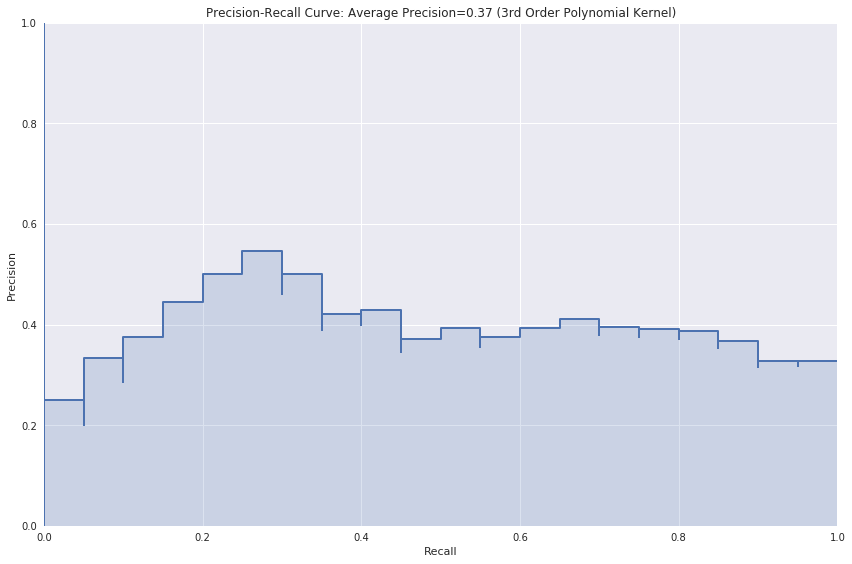

In [17]:
def get_classifier_poly_3(df_train_X, df_train_y, df_eval_X, df_eval_y):
  # Generate candidate C values on a logarithmic scale between 0.01 and 1000
  C_values = np.logspace(-2., 5., 1000)
  classifier_svc_poly_3 = None
  classifier_svc_poly_3_results = {
    'classifier': np.array([]), 
    'C': np.array([]), 
    'f1': np.array([]),
    'tp': np.array([]),
    'tn': np.array([]),
    'fp': np.array([]),
    'fn': np.array([]),
    'report': np.array([]),
    'fpr': np.array([]),
    'tpr': np.array([]),
    'roc_auc': np.array([]),
    'average_precision': np.array([]),
    'precision': np.array([]),
    'recall': np.array([]),
    'pr_auc': np.array([])
  }

  # Train a model with each of these C values and output results on eval set
  for C in C_values:

    # Create and fit classifier
    classifier_svc_poly_3 = SVC(C=C, kernel='poly', probability=True, class_weight='balanced', random_state=RANDOM_STATE)
    classifier_svc_poly_3.fit(df_train_X, df_train_y)

    # Evaluate with evaluation set
    eval_true = df_eval_y
    eval_preds = classifier_svc_poly_3.predict(df_eval_X)
    eval_probs = classifier_svc_poly_3.predict_proba(df_eval_X)

    # Compute metrics
    f1 = metrics.f1_score(eval_true, eval_preds)
    tn, fp, fn, tp = metrics.confusion_matrix(eval_true, eval_preds).ravel()
    report = metrics.classification_report(eval_true, eval_preds)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = metrics.roc_curve(eval_true, eval_probs[:,1], pos_label=True)
    roc_auc = metrics.auc(fpr, tpr)

    # Compute PR curve and PR area for each class
    average_precision = metrics.average_precision_score(eval_true, eval_preds)
    precision, recall, _ = metrics.precision_recall_curve(eval_true, eval_probs[:,1], pos_label=True)
    pr_auc = metrics.auc(precision, recall, reorder=True)

    # If we didn't predict everything as one class, save C and F1 score for visualization
    if (tp + fp != 0) and (tn + fn != 0):
      classifier_svc_poly_3_results['classifier'] = np.append(classifier_svc_poly_3_results['classifier'], classifier_svc_poly_3)
      classifier_svc_poly_3_results['C'] = np.append(classifier_svc_poly_3_results['C'], C)
      classifier_svc_poly_3_results['f1'] = np.append(classifier_svc_poly_3_results['f1'], f1)
      classifier_svc_poly_3_results['report'] = np.append(classifier_svc_poly_3_results['report'], report)
      classifier_svc_poly_3_results['tp'] = np.append(classifier_svc_poly_3_results['tp'], tp)
      classifier_svc_poly_3_results['tn'] = np.append(classifier_svc_poly_3_results['tn'], tn)
      classifier_svc_poly_3_results['fp'] = np.append(classifier_svc_poly_3_results['fp'], fp)
      classifier_svc_poly_3_results['fn'] = np.append(classifier_svc_poly_3_results['fn'], fn)
      classifier_svc_poly_3_results['fpr'] = np.append(classifier_svc_poly_3_results['fpr'], fpr)
      classifier_svc_poly_3_results['tpr'] = np.append(classifier_svc_poly_3_results['tpr'], tpr)
      classifier_svc_poly_3_results['roc_auc'] = np.append(classifier_svc_poly_3_results['roc_auc'], roc_auc)
      classifier_svc_poly_3_results['average_precision'] = np.append(classifier_svc_poly_3_results['average_precision'], average_precision)
      classifier_svc_poly_3_results['precision'] = np.append(classifier_svc_poly_3_results['precision'], precision)
      classifier_svc_poly_3_results['recall'] = np.append(classifier_svc_poly_3_results['recall'], recall)
      classifier_svc_poly_3_results['pr_auc'] = np.append(classifier_svc_poly_3_results['pr_auc'], pr_auc)

  # Plot results from F1 tuning
  lw = 2
  figure = plt.figure(figsize=(12,8))
  plt.plot(classifier_svc_poly_3_results['C'], classifier_svc_poly_3_results['f1'], lw=lw)
  plt.xscale('log')
  plt.xlabel('F1 score')
  plt.ylim([0, 1])
  plt.ylabel('C')
  plt.title('F1 scores for values of C')
  plt.tight_layout()

  # Find best classifier
  max_f1_index = classifier_svc_poly_3_results['f1'].argmax()

  # Print results for best classifier
  best_classifier = classifier_svc_poly_3_results['classifier'][max_f1_index]
  print('Results for classifier with C={}:'.format(classifier_svc_poly_3_results['C'][max_f1_index]))
  print('\n')
  print('Overall F1 score: {}'.format(classifier_svc_poly_3_results['f1'][max_f1_index]))
  print('True positives: {}'.format(classifier_svc_poly_3_results['tp'][max_f1_index]))
  print('True negatives: {}'.format(classifier_svc_poly_3_results['tn'][max_f1_index]))
  print('False positives: {}'.format(classifier_svc_poly_3_results['fp'][max_f1_index]))
  print('False negatives: {}'.format(classifier_svc_poly_3_results['fn'][max_f1_index]))
  print('\n')
  print(classifier_svc_poly_3_results['report'][max_f1_index])

  # Plot ROC curve for best classifier
  figure = plt.figure(figsize=(12,8))
  plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (3rd Order Polynomial Kernel)')
  plt.legend(loc="lower right")
  plt.tight_layout()

  # Plot precision-recall curve for best classifier
  figure = plt.figure(figsize=(12,8))
  plt.step(recall, precision, where='post', lw=lw)
  plt.fill_between(recall, precision, step='post', alpha=0.2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve: Average Precision={0:0.2f} (3rd Order Polynomial Kernel)'.format(average_precision))
  plt.tight_layout()

  # Save best classifier
  return best_classifier

classifier_svc_poly_3 = get_classifier_poly_3(df_train_X, df_train_y, df_eval_X, df_eval_y)

## Build SVM classifier (8th Order Polynomial Kernel)

Now, we build an SVM classifier and trial various parameters for the $C \in [0.01, 100000]$ term in the model (the error penalization term). This model uses a 8th order polynomial kernel.

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Results for classifier with C=259.6655972934872:


Overall F1 score: 0.5671641791044776
True positives: 19.0
True negatives: 13.0
False positives: 28.0
False negatives: 1.0


             precision    recall  f1-score   support

      False       0.93      0.32      0.47        41
       True       0.40      0.95      0.57        20

avg / total       0.76      0.52      0.50        61



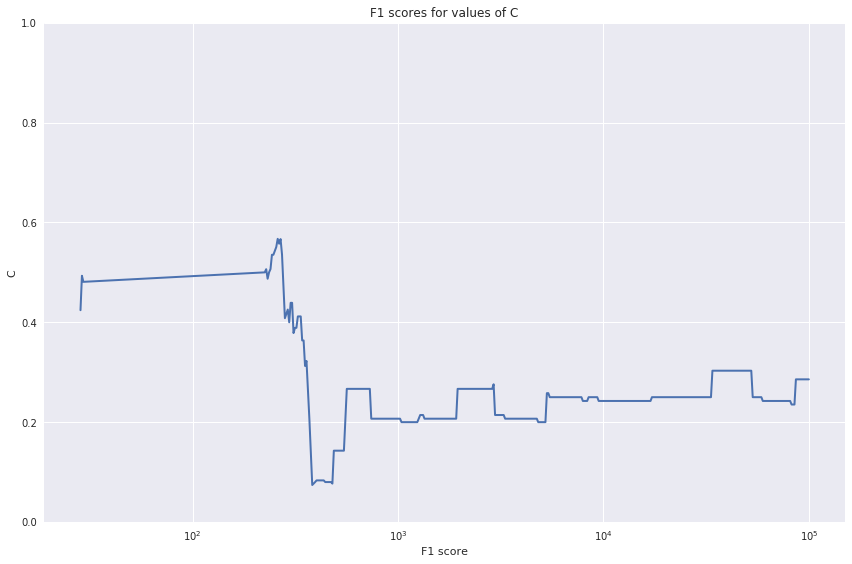

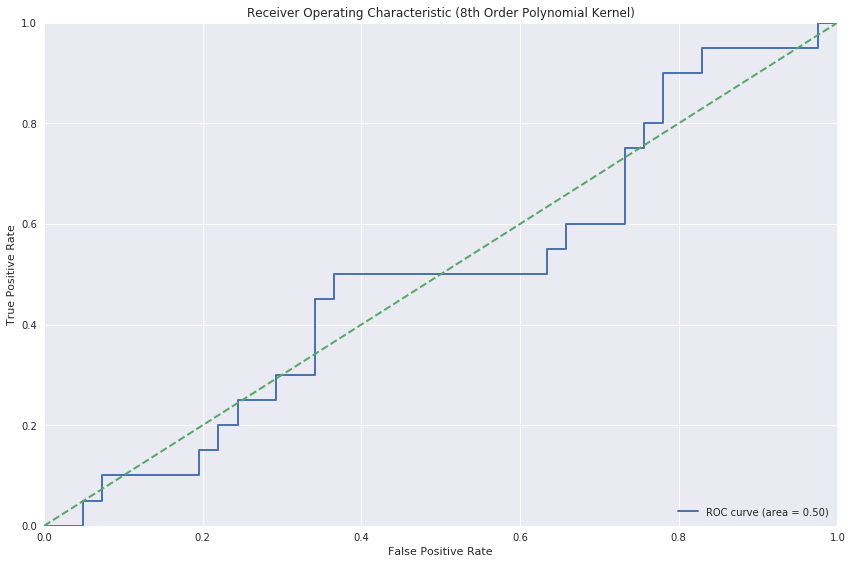

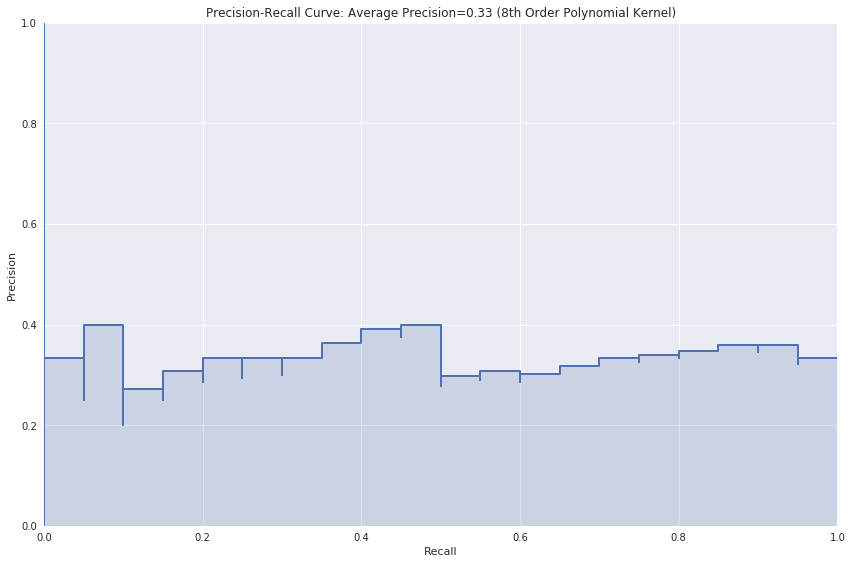

In [18]:
def get_classifier_poly_8(df_train_X, df_train_y, df_eval_X, df_eval_y):
  # Generate candidate C values on a logarithmic scale between 0.01 and 1000
  C_values = np.logspace(-2., 5., 1000)
  classifier_svc_poly_8 = None
  classifier_svc_poly_8_results = {
    'classifier': np.array([]), 
    'C': np.array([]), 
    'f1': np.array([]),
    'tp': np.array([]),
    'tn': np.array([]),
    'fp': np.array([]),
    'fn': np.array([]),
    'report': np.array([]),
    'fpr': np.array([]),
    'tpr': np.array([]),
    'roc_auc': np.array([]),
    'average_precision': np.array([]),
    'precision': np.array([]),
    'recall': np.array([]),
    'pr_auc': np.array([])
  }

  # Train a model with each of these C values and output results on eval set
  for C in C_values:

    # Create and fit classifier
    classifier_svc_poly_8 = SVC(C=C, kernel='poly', degree=8, probability=True, class_weight='balanced', random_state=RANDOM_STATE)
    classifier_svc_poly_8.fit(df_train_X, df_train_y)

    # Evaluate with evaluation set
    eval_true = df_eval_y
    eval_preds = classifier_svc_poly_8.predict(df_eval_X)
    eval_probs = classifier_svc_poly_8.predict_proba(df_eval_X)

    # Compute metrics
    f1 = metrics.f1_score(eval_true, eval_preds)
    tn, fp, fn, tp = metrics.confusion_matrix(eval_true, eval_preds).ravel()
    report = metrics.classification_report(eval_true, eval_preds)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = metrics.roc_curve(eval_true, eval_probs[:,1], pos_label=True)
    roc_auc = metrics.auc(fpr, tpr)

    # Compute PR curve and PR area for each class
    average_precision = metrics.average_precision_score(eval_true, eval_preds)
    precision, recall, _ = metrics.precision_recall_curve(eval_true, eval_probs[:,1], pos_label=True)
    pr_auc = metrics.auc(precision, recall, reorder=True)

    # If we didn't predict everything as one class, save C and F1 score for visualization
    if (tp + fp != 0) and (tn + fn != 0):
      classifier_svc_poly_8_results['classifier'] = np.append(classifier_svc_poly_8_results['classifier'], classifier_svc_poly_8)
      classifier_svc_poly_8_results['C'] = np.append(classifier_svc_poly_8_results['C'], C)
      classifier_svc_poly_8_results['f1'] = np.append(classifier_svc_poly_8_results['f1'], f1)
      classifier_svc_poly_8_results['report'] = np.append(classifier_svc_poly_8_results['report'], report)
      classifier_svc_poly_8_results['tp'] = np.append(classifier_svc_poly_8_results['tp'], tp)
      classifier_svc_poly_8_results['tn'] = np.append(classifier_svc_poly_8_results['tn'], tn)
      classifier_svc_poly_8_results['fp'] = np.append(classifier_svc_poly_8_results['fp'], fp)
      classifier_svc_poly_8_results['fn'] = np.append(classifier_svc_poly_8_results['fn'], fn)
      classifier_svc_poly_8_results['fpr'] = np.append(classifier_svc_poly_8_results['fpr'], fpr)
      classifier_svc_poly_8_results['tpr'] = np.append(classifier_svc_poly_8_results['tpr'], tpr)
      classifier_svc_poly_8_results['roc_auc'] = np.append(classifier_svc_poly_8_results['roc_auc'], roc_auc)
      classifier_svc_poly_8_results['average_precision'] = np.append(classifier_svc_poly_8_results['average_precision'], average_precision)
      classifier_svc_poly_8_results['precision'] = np.append(classifier_svc_poly_8_results['precision'], precision)
      classifier_svc_poly_8_results['recall'] = np.append(classifier_svc_poly_8_results['recall'], recall)
      classifier_svc_poly_8_results['pr_auc'] = np.append(classifier_svc_poly_8_results['pr_auc'], pr_auc)

  # Plot results from F1 tuning
  lw = 2
  figure = plt.figure(figsize=(12,8))
  plt.plot(classifier_svc_poly_8_results['C'], classifier_svc_poly_8_results['f1'], lw=lw)
  plt.xscale('log')
  plt.xlabel('F1 score')
  plt.ylim([0, 1])
  plt.ylabel('C')
  plt.title('F1 scores for values of C')
  plt.tight_layout()

  # Find best classifier
  max_f1_index = classifier_svc_poly_8_results['f1'].argmax()

  # Print results for best classifier
  best_classifier = classifier_svc_poly_8_results['classifier'][max_f1_index]
  print('Results for classifier with C={}:'.format(classifier_svc_poly_8_results['C'][max_f1_index]))
  print('\n')
  print('Overall F1 score: {}'.format(classifier_svc_poly_8_results['f1'][max_f1_index]))
  print('True positives: {}'.format(classifier_svc_poly_8_results['tp'][max_f1_index]))
  print('True negatives: {}'.format(classifier_svc_poly_8_results['tn'][max_f1_index]))
  print('False positives: {}'.format(classifier_svc_poly_8_results['fp'][max_f1_index]))
  print('False negatives: {}'.format(classifier_svc_poly_8_results['fn'][max_f1_index]))
  print('\n')
  print(classifier_svc_poly_8_results['report'][max_f1_index])

  # Plot ROC curve for best classifier
  figure = plt.figure(figsize=(12,8))
  plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (8th Order Polynomial Kernel)')
  plt.legend(loc="lower right")
  plt.tight_layout()

  # Plot precision-recall curve for best classifier
  figure = plt.figure(figsize=(12,8))
  plt.step(recall, precision, where='post', lw=lw)
  plt.fill_between(recall, precision, step='post', alpha=0.2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve: Average Precision={0:0.2f} (8th Order Polynomial Kernel)'.format(average_precision))
  plt.tight_layout()

  # Save best classifier
  return best_classifier

classifier_svc_poly_8 = get_classifier_poly_8(df_train_X, df_train_y, df_eval_X, df_eval_y)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Results for classifier with C=0.010471768194855203:


Overall F1 score: 0.47058823529411764
True positives: 12.0
True negatives: 22.0
False positives: 19.0
False negatives: 8.0


             precision    recall  f1-score   support

      False       0.73      0.54      0.62        41
       True       0.39      0.60      0.47        20

avg / total       0.62      0.56      0.57        61



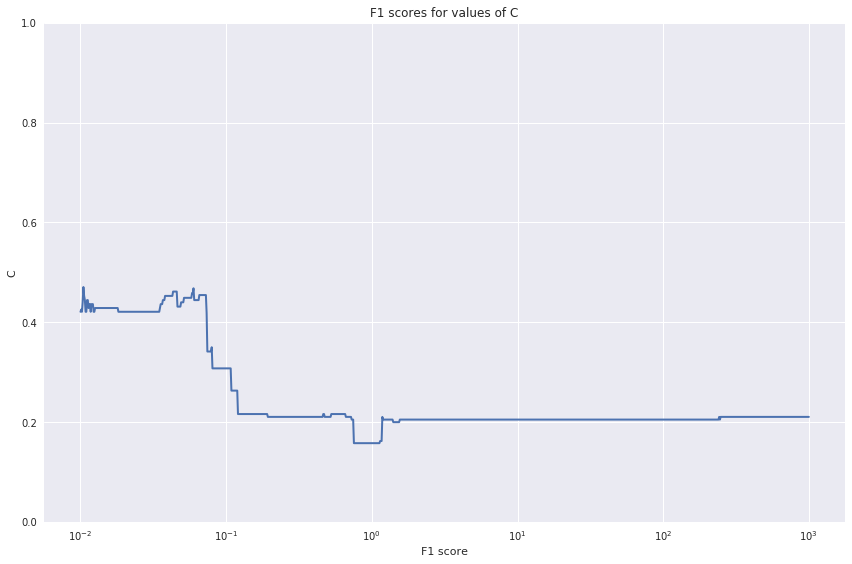

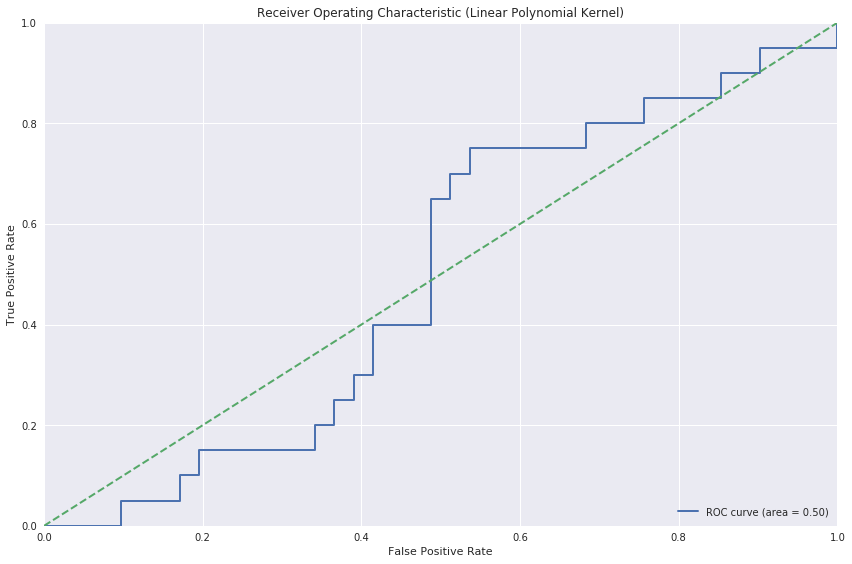

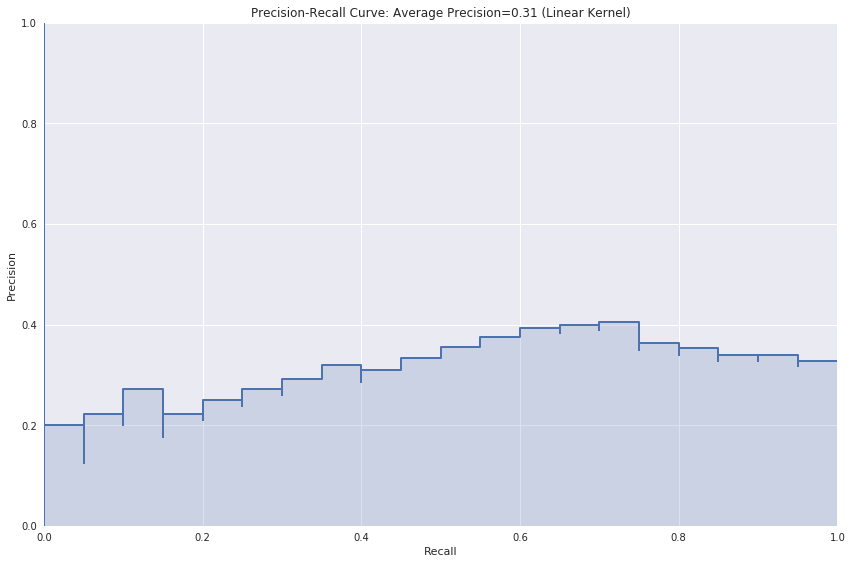

In [15]:
def get_classifier_linear(df_train_X, df_train_y, df_eval_X, df_eval_y):
  # Generate candidate C values on a logarithmic scale between 0.01 and 1000
  C_values = np.logspace(-2., 3., 1000)
  classifier_svc_linear = None
  classifier_svc_linear_results = {
    'classifier': np.array([]), 
    'C': np.array([]), 
    'f1': np.array([]),
    'tp': np.array([]),
    'tn': np.array([]),
    'fp': np.array([]),
    'fn': np.array([]),
    'report': np.array([]),
    'fpr': np.array([]),
    'tpr': np.array([]),
    'roc_auc': np.array([]),
    'average_precision': np.array([]),
    'precision': np.array([]),
    'recall': np.array([]),
    'pr_auc': np.array([])
  }

  # Train a model with each of these C values and output results on eval set
  for C in C_values:
    
    # Create and fit classifier
    classifier_svc_linear = SVC(C=C, kernel='linear', probability=True, class_weight='balanced', random_state=RANDOM_STATE)
    classifier_svc_linear.fit(df_train_X, df_train_y)

    # Evaluate with evaluation set
    eval_true = df_eval_y
    eval_preds = classifier_svc_linear.predict(df_eval_X)
    eval_probs = classifier_svc_linear.predict_proba(df_eval_X)

    # Compute metrics
    f1 = metrics.f1_score(eval_true, eval_preds)
    tn, fp, fn, tp = metrics.confusion_matrix(eval_true, eval_preds).ravel()
    report = metrics.classification_report(eval_true, eval_preds)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = metrics.roc_curve(eval_true, eval_probs[:,1], pos_label=True)
    roc_auc = metrics.auc(fpr, tpr)

    # Compute PR curve and PR area for each class
    average_precision = metrics.average_precision_score(eval_true, eval_preds)
    precision, recall, _ = metrics.precision_recall_curve(eval_true, eval_probs[:,1], pos_label=True)
    pr_auc = metrics.auc(precision, recall, reorder=True)

    # If we didn't predict everything as one class, save C and F1 score for visualization
    if (tp + fp != 0) and (tn + fn != 0):
      classifier_svc_linear_results['classifier'] = np.append(classifier_svc_linear_results['classifier'], classifier_svc_linear)
      classifier_svc_linear_results['C'] = np.append(classifier_svc_linear_results['C'], C)
      classifier_svc_linear_results['f1'] = np.append(classifier_svc_linear_results['f1'], f1)
      classifier_svc_linear_results['report'] = np.append(classifier_svc_linear_results['report'], report)
      classifier_svc_linear_results['tp'] = np.append(classifier_svc_linear_results['tp'], tp)
      classifier_svc_linear_results['tn'] = np.append(classifier_svc_linear_results['tn'], tn)
      classifier_svc_linear_results['fp'] = np.append(classifier_svc_linear_results['fp'], fp)
      classifier_svc_linear_results['fn'] = np.append(classifier_svc_linear_results['fn'], fn)
      classifier_svc_linear_results['fpr'] = np.append(classifier_svc_linear_results['fpr'], fpr)
      classifier_svc_linear_results['tpr'] = np.append(classifier_svc_linear_results['tpr'], tpr)
      classifier_svc_linear_results['roc_auc'] = np.append(classifier_svc_linear_results['roc_auc'], roc_auc)
      classifier_svc_linear_results['average_precision'] = np.append(classifier_svc_linear_results['average_precision'], average_precision)
      classifier_svc_linear_results['precision'] = np.append(classifier_svc_linear_results['precision'], precision)
      classifier_svc_linear_results['recall'] = np.append(classifier_svc_linear_results['recall'], recall)
      classifier_svc_linear_results['pr_auc'] = np.append(classifier_svc_linear_results['pr_auc'], pr_auc)

  # Plot results from F1 tuning
  lw = 2
  figure = plt.figure(figsize=(12,8))
  plt.plot(classifier_svc_linear_results['C'], classifier_svc_linear_results['f1'], lw=lw)
  plt.xscale('log')
  plt.xlabel('F1 score')
  plt.ylim([0, 1])
  plt.ylabel('C')
  plt.title('F1 scores for values of C')
  plt.tight_layout()

  # Find best classifier
  max_f1_index = classifier_svc_linear_results['f1'].argmax()

  # Print results for best classifier
  best_classifier = classifier_svc_linear_results['classifier'][max_f1_index]
  print('Results for classifier with C={}:'.format(classifier_svc_linear_results['C'][max_f1_index]))
  print('\n')
  print('Overall F1 score: {}'.format(classifier_svc_linear_results['f1'][max_f1_index]))
  print('True positives: {}'.format(classifier_svc_linear_results['tp'][max_f1_index]))
  print('True negatives: {}'.format(classifier_svc_linear_results['tn'][max_f1_index]))
  print('False positives: {}'.format(classifier_svc_linear_results['fp'][max_f1_index]))
  print('False negatives: {}'.format(classifier_svc_linear_results['fn'][max_f1_index]))
  print('\n')
  print(classifier_svc_linear_results['report'][max_f1_index])

  # Plot ROC curve for best classifier
  figure = plt.figure(figsize=(12,8))
  plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (Linear Polynomial Kernel)')
  plt.legend(loc="lower right")
  plt.tight_layout()

  # Plot precision-recall curve for best classifier
  figure = plt.figure(figsize=(12,8))
  plt.step(recall, precision, where='post', lw=lw)
  plt.fill_between(recall, precision, step='post', alpha=0.2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve: Average Precision={0:0.2f} (Linear Kernel)'.format(average_precision))
  plt.tight_layout()

  # Save best classifier
  return best_classifier

classifier_svc_linear = get_classifier_linear(df_train_X, df_train_y, df_eval_X, df_eval_y)

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

eclf1_clf_linear = SVC(C=best_C_linear, kernel='linear', probability=True, class_weight='balanced')
eclf1_clf_poly_3 = SVC(C=best_C_poly_3, kernel='poly', degree=3, probability=True, class_weight='balanced')
eclf1_clf_poly_8 = SVC(C=best_C_poly_8, kernel='poly', degree=8, probability=True, class_weight='balanced')
eclf1_clf_sigmoid = SVC(C=best_C_sigmoid, kernel='sigmoid', probability=True, class_weight='balanced')
eclf1_clf_rbf = SVC(C=best_C_rbf, kernel='rbf', probability=True, class_weight='balanced', random_state=1)

X = df_train_X
y = df_train_y

eclf1 = VotingClassifier(estimators=[
                                      ('linear', eclf1_clf_linear), 
                                      ('poly_3', eclf1_clf_poly_3), 
                                      ('poly_8', eclf1_clf_poly_8), 
                                      ('sigmoid', eclf1_clf_sigmoid),
                                      ('rbf', eclf1_clf_rbf),
#                                       ('logistic', clf1),
#                                       ('random_forest', clf2),
                                      ('naive_bayes', clf3)
                                    ], 
                         voting='hard')
#                          weights=[1., 1., 1., 1., 1.])
# eclf1 = VotingClassifier(estimators=[('rbf', eclf1_clf_rbf)], 
#                          voting='soft',
#                          weights=[1.])
# eclf1 = eclf1_clf_rbf

eclf1 = eclf1.fit(X, y)
eclf1_pred = eclf1.predict(df_eval_X)
# eclf1_probs = eclf1.predict_proba(df_eval_X)

f1 = f1_score(df_eval_y, eclf1_pred)

print("\n")
print("F1 score: {}".format(f1))

tn, fp, fn, tp = confusion_matrix(df_eval_y, eclf1_pred).ravel()
print("True negatives: {}".format(tn))
print("True positives: {}".format(tp))
print("False negatives: {}".format(fn))
print("False positives: {}".format(fp))
print("\n")

# print(zip(df_eval_y, eclf1_pred))

report = classification_report(df_eval_y, eclf1_pred)
print(report)

# Compute ROC curve and ROC area for each class
# fpr = None
# tpr = None
# roc_auc = None

# fpr, tpr, thresholds = roc_curve(df_eval_y, eclf1_probs[:,1], pos_label=True)
# roc_auc = auc(fpr, tpr)

# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (Linear Kernel)')
# plt.legend(loc="lower right")
# plt.show()



# eclf2 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')
# eclf2 = eclf2.fit(X, y)
# print(eclf2.predict(X))
# eclf3 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[2,1,1], flatten_transform=True)
# eclf3 = eclf3.fit(X, y)
# print(eclf3.predict(X))
# print(eclf3.transform(X).shape)

# print(eclf1.get_params())

- Take a close look at the questionnaire responses of misclassified cases
- Determine statistical significance (or not) of ensemble classifier